In [82]:
# %matplotlib notebook
%matplotlib inline

import numpy as np
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from trajectories import simulate, simulate_rotation, get_view_vector, std_from_r, trajectory, simulate_c
from metric import rmse

from filterpy.kalman import KalmanFilter, UnscentedKalmanFilter as UKF, ExtendedKalmanFilter as EKF
from filterpy.common import Q_discrete_white_noise
import pickle

In [15]:
from data_utils import np_from_traj, np_from_traj_camera, vis_3d, vis_all_coords, load_pickle
from akaze_calibrator import compute_pose_matrix

In [3]:
mt_data = load_pickle("/home/nrogovoy/Downloads/mt_data.pkl")
camera_data = load_pickle("/home/nrogovoy/Downloads/a04fbb6d-9f4d-4c7c-b8fa-8c1b8bdd1497/export/camera_data.pkl")

In [59]:
mt_traj, mt_rot = np_from_traj(mt_data)
cam_traj, cam_rot, cam_acc = np_from_traj_camera(camera_data)
mt_traj = mt_traj[:-1]
mt_rot = mt_rot[:-1]
cam_traj = cam_traj[:-1]
cam_rot = cam_rot[:-1]
cam_acc = cam_acc[:-1]
mt_rot[:, 0] = np.abs(mt_rot[:, 0]) - 180

In [13]:
Re, T = compute_pose_matrix(cam_traj, mt_traj)
cam_traj_t = (cam_traj @ (Re.T) + T)
# cam_acc_t = cam_acc @ Re.T
Re, T = compute_pose_matrix(cam_rot, mt_rot)
cam_rot_t = (cam_rot @ (Re.T) + T)


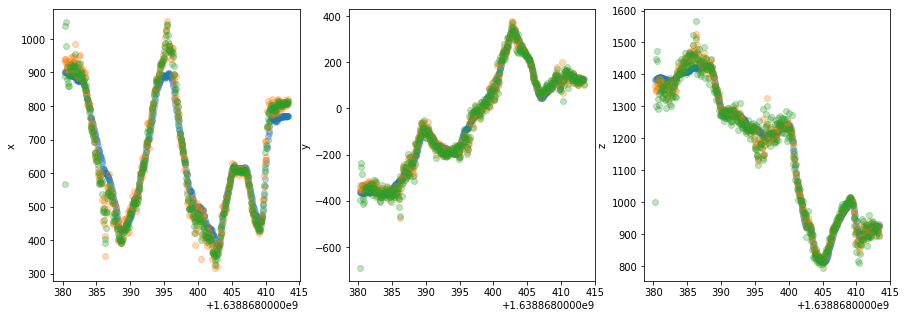

In [93]:
vis_all_coords([cam_traj_t[1:], mt_traj[1:], filtered_traj], timestamps[1:], ['x', 'y', 'z'])

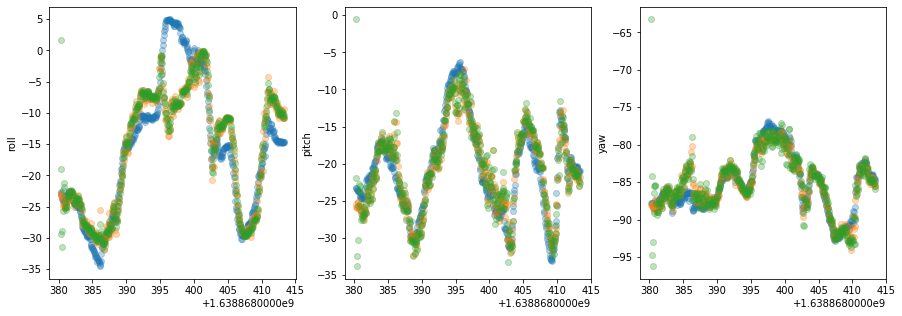

In [88]:
vis_all_coords([cam_rot_t[1:], mt_rot[1:], filtered_traj], timestamps[1:], ['roll', 'pitch', 'yaw'])

ValueError: x and y must be the same size

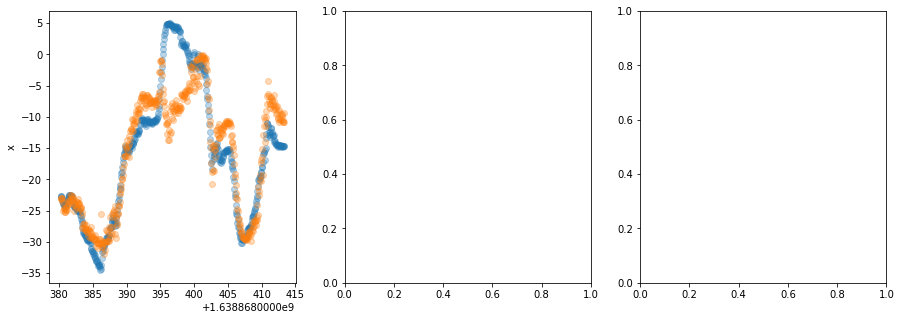

In [89]:
vis_all_coords([cam_rot_t, mt_rot, filtered_traj], timestamps, ['x', 'y', 'z'])

In [91]:
kf = KalmanFilter(dim_x=9, dim_z=3)
dt = 1
# kf.x = [ms_traj[0][0], ms_traj[0][1], ms_traj[0][2], 0., 0., 0., 0., 0., 0.]
kf.x = [0., 0., 0., 0., 0., 0., 0., 0., 0.]

# x, y, z, x', y', z',
kf.F = np.array([
    [1., 0., 0., dt, 0., 0., dt**2 / 2, 0., 0.],
    [0., 1., 0., 0., dt, 0., 0., dt**2 / 2, 0.],
    [0., 0., 1., 0., 0., dt, 0., 0., dt**2 / 2],
    [0., 0., 0., 1., 0., 0., dt, 0., 0.],
    [0., 0., 0., 0., 1., 0., 0., dt, 0.],
    [0., 0., 0., 0., 0., 1., 0., 0., dt],
    [0., 0., 0., 0., 0., 0., 1., 0., 0.],
    [0., 0., 0., 0., 0., 0., 0., 1., 0.],
    [0., 0., 0., 0., 0., 0., 0., 0., 1.],
])    # state transition matrix

kf.H = np.array([
    [1., 0., 0., 0, 0, 0, 0, 0, 0],
    [0., 1., 0., 0, 0, 0, 0, 0, 0],
    [0., 0., 1., 0, 0, 0, 0, 0, 0],
#     [0., 0., 0., 0, 0, 0, 1, 0, 0],
#     [0., 0., 0., 0, 0, 0, 0, 1, 0],
#     [0., 0., 0., 0, 0, 0, 0, 0, 1],
])    # Measurement function
# my_filter.P                  # covariance matrix
kf.R = 1#std_from_r(0.001, radius)                      # state uncertainty
kf.Q = Q_discrete_white_noise(3, dt, 0.1, 3) # process uncertainty


In [92]:
filtered_traj = []
for i in range(1, len(mt_traj)):
    kf.predict()
    y = [mt_traj[i][0], mt_traj[i][1], mt_traj[i][2]]#, cam_acc[i][0], cam_acc[i][2], cam_acc[i][2]]
    kf.update(y)
    x = kf.x
    filtered_traj.append(x)
filtered_traj = np.array(filtered_traj)